In [ ]:
from tsai.all import *
import pandas as pd
from datenverarbeitung.dataloader import dataloader
from IPython.display import clear_output
import datetime


num_scenario = 3
nr_taps = 1
learning_cycles = 25
features_to_learn_with = ["pitch","nosetip_y","nosetip_x","chin_x","chin_y","roll","yaw","left_eye_corner_x","left_eye_corner_y","right_eye_corner_x","right_eye_corner_y","left_mouth_corner_x","left_mouth_corner_y","right_mouth_corner_x","right_mouth_corner_y","nose_end_point_x","nose_end_point_y","head_pose1_x","head_pose1_y","head_pose2_x","head_pose2_y"]
feature_list_string = '_'.join(features_to_learn_with)
models_folder = "models"
plots_folder = "vis/plots"

dl = dataloader(scenario= num_scenario, path="/Users/adi/Nextcloud/smart_hans/AP2/Daten/headpose_opencv_pitch_roll_yaw_20220904", nr_taps=nr_taps, move_window_by=-10, feature_list=features_to_learn_with)
df_n = dl.df

cols = list(df_n.columns)
a, b = cols.index('sample_index'), cols.index('feature')
cols[b], cols[a] = cols[a], cols[b]
df_n = df_n[cols]
print(df_n)
df_n = df_n.sort_values(['feature','target'])#.reset_index(drop=True)

print(df_n["feature"])
print(df_n['sample_index'])
print(" hhhhhhhh ")

X, old_y, names = df2xy (df_n, sample_col='sample_index', feat_col='feature', target_col='target', data_cols=None, steps_in_rows=True, return_names=True)

print(names)
print(f"shape ours {df_n.shape}")

print("our X")
print(X.shape)
print(X)

print("our y")
print(old_y)
print(old_y.shape)

y = np.empty(len(old_y))
for i, elem in enumerate(old_y):
            remainder = int(elem[0]) % 10
            y[i] = remainder
print(y)
print(y.shape)
   
splits = get_splits(y, valid_size=.2)

tfms  = [None, TSRegression()]

dsets = TSDatasets( X,y,  inplace=True, splits=splits, tfms=[None, TSClassification()])

print(dsets)

dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, num_workers=0, tfms=[None, TSClassification()], item_tfs=TSClassification())

dls.show_batch(sharey=True)

archs = [(FCN, {}), (ResNet, {}), (xresnet1d34, {}), (ResCNN, {}), 
        (LSTM, {'n_layers':1, 'bidirectional': False}), (LSTM, {'n_layers':2, 'bidirectional': False}), (LSTM, {'n_layers':3, 'bidirectional': False}), 
        (LSTM, {'n_layers':1, 'bidirectional': True}), (LSTM, {'n_layers':2, 'bidirectional': True}), (LSTM, {'n_layers':3, 'bidirectional': True}),
        (LSTM_FCN, {}), (LSTM_FCN, {'shuffle': False}), (InceptionTime, {}), (XceptionTime, {}), (OmniScaleCNN, {}), (mWDN, {'levels': 4})]

results = pd.DataFrame(columns=['arch', 'hyperparams',  'train loss', 'valid loss', 'accuracy', 'time'])
for i, (arch, k) in enumerate(archs):

    save_name = "multivariate_scenario_{}_{}_features_{}".format(num_scenario, arch.__name__,"features_"+str(len(features_to_learn_with)))
    ## set parameters for modelsaves
    scenario_name_stage0 = save_name+"_nr_taps_{}".format(str(nr_taps))+"_stage0"

    model = create_model(arch, dls=dls, **k)
    print(model.__class__.__name__)
    learn = Learner(dls, model,  metrics=accuracy)

    learn.save(scenario_name_stage0)
    learn.load(scenario_name_stage0)
    learn.lr_find()
    scenario_name_stage1 = scenario_name_stage0.replace("0","1")

    start = time.time()
    learn.fit_one_cycle(learning_cycles, 1e-3)
    elapsed = time.time() - start
    vals = learn.recorder.values[-1]
    results.loc[i] = [arch.__name__, k, vals[0], vals[1], vals[2], int(elapsed)]
    results.sort_values(by='accuracy', ascending=False, ignore_index=True, inplace=True)
    
    learn.plot_confusion_matrix()
    current_time= datetime.datetime.now().strftime('%d%m%Y_%H%M%S')
    plot_name = plots_folder+"/confusion_matrix_"+save_name+"_nrtaps_{}_features_{}_learning_cycles_{}_{}.png".format(str(nr_taps),str(len(features_to_learn_with)),learning_cycles, current_time)
    plt.savefig(plot_name, ext='png', bbox_inches="tight")
    clear_output(wait=True)
    display(results)


In [ ]:
tap_sizes = [10,20,30,40,50,60,70,80]
movers = [20,15,10,5, 0, -5, -10, -15, -20]
all_features = ["nosetip_x","nosetip_y","chin_x","chin_y","left_eye_corner_x","left_eye_corner_y","right_eye_corner_x","right_eye_corner_y","left_mouth_corner_x","left_mouth_corner_y","right_mouth_corner_x","right_mouth_corner_y","nose_end_point_x","nose_end_point_y","head_pose1_x","head_pose1_y","head_pose2_x","head_pose2_y", "pitch","roll","yaw"]
features_to_learn_with = []
counter = 0 
for i in range(0,len(all_features),2):
    if (i<len(all_features)-2):
        features_to_learn_with.append(all_features[i])
        features_to_learn_with.append(all_features[i+1])
    else :
        features_to_learn_with.append(all_features[i])
    for tap_size in tap_sizes:
        for move_by in movers:
            
            counter += 1
    



,arch,hyperparams,train loss,valid loss,accuracy,time
0,FCN,{},0.683327,0.792929,0.320755,1
1,ResNet,{},0.689735,0.847526,0.320755,1


XResNet


epoch,train_loss,valid_loss,accuracy,time
0,0.799658,0.697767,0.471698,00:00
1,0.776459,0.670489,0.584906,00:00
2,0.751484,0.704944,0.528302,00:00
3,0.744891,0.741123,0.528302,00:00
4,0.741430,0.719330,0.547170,00:00
5,0.742351,0.699935,0.603774,00:00
6,0.738317,0.678437,0.584906,00:00
7,0.735444,0.700884,0.547170,00:00
8,0.730232,0.756015,0.377358,00:00
9,0.728971,0.771234,0.377358,00:00


RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

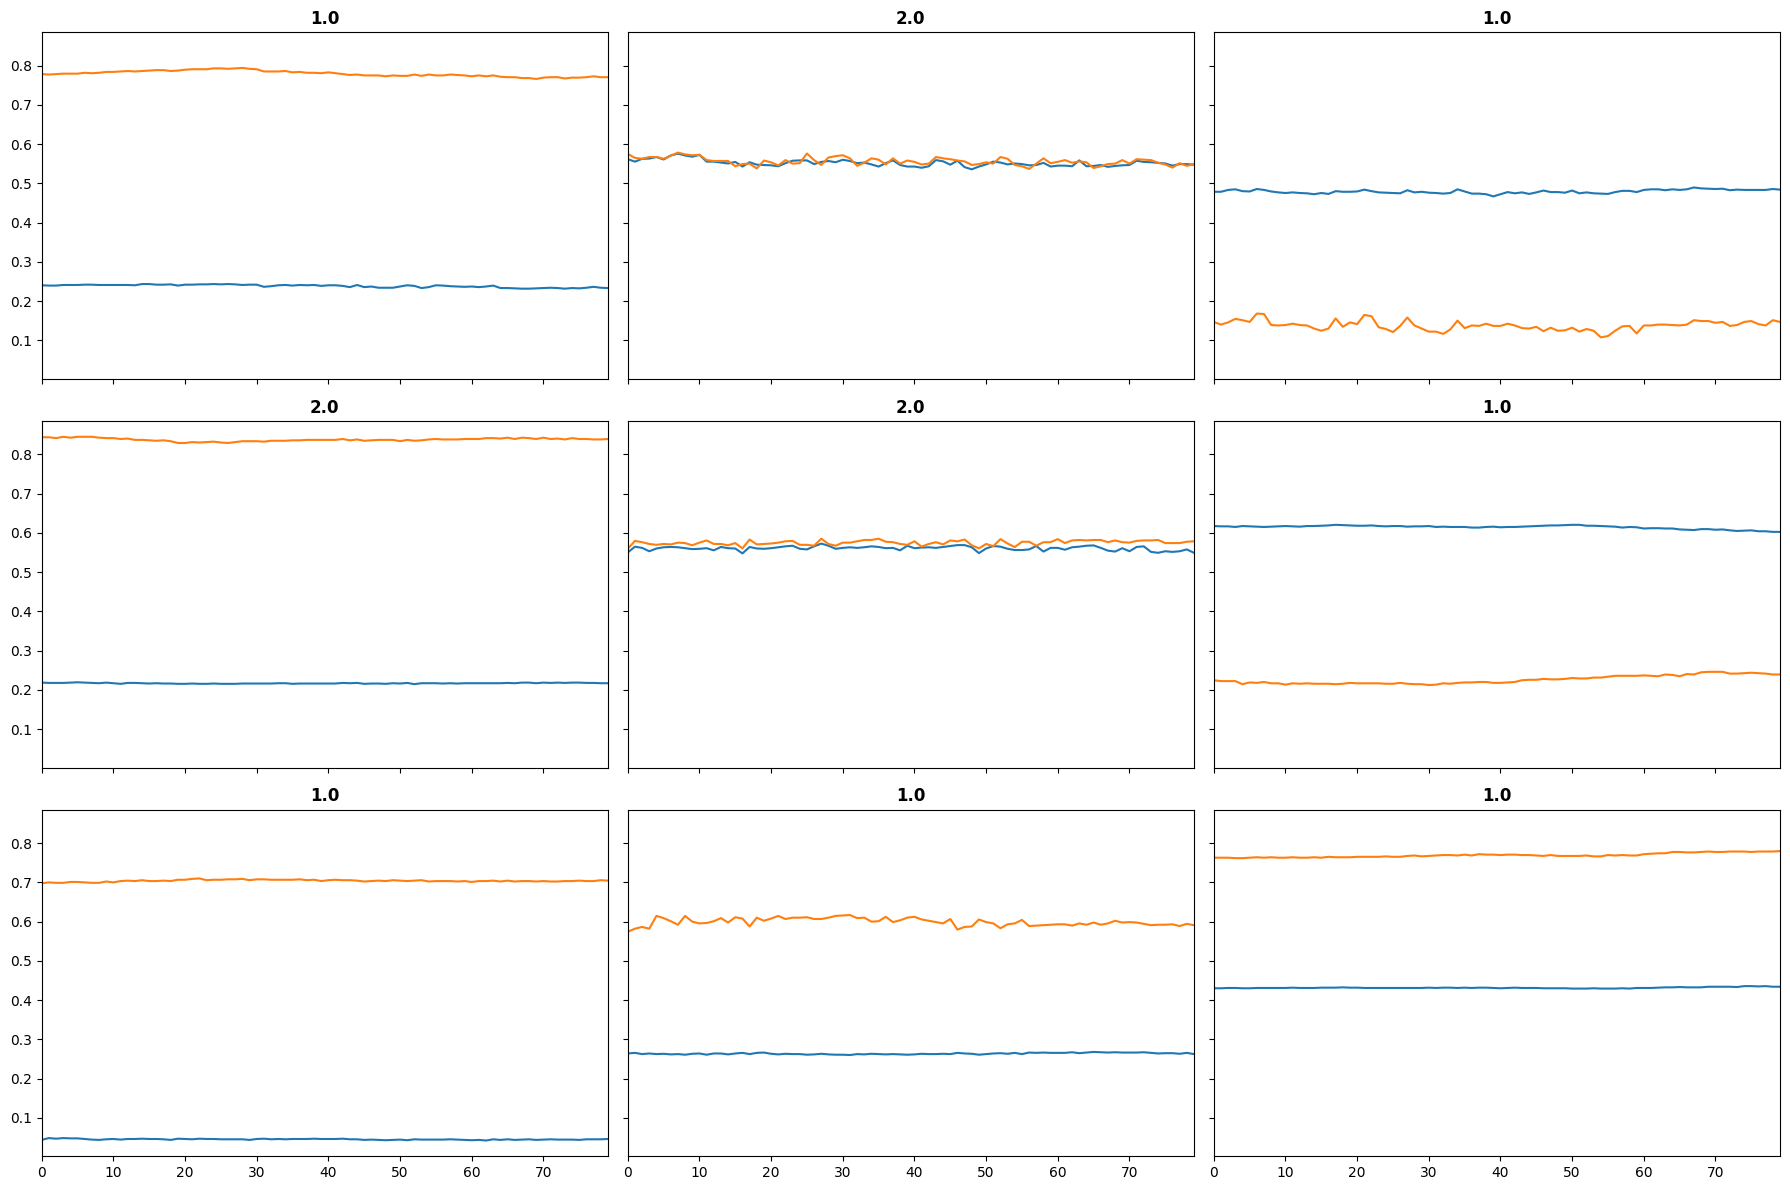

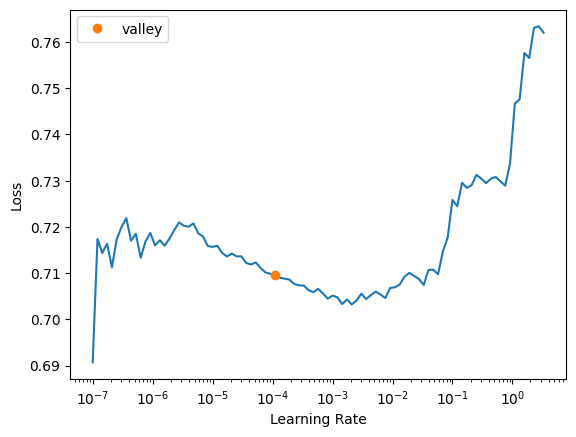

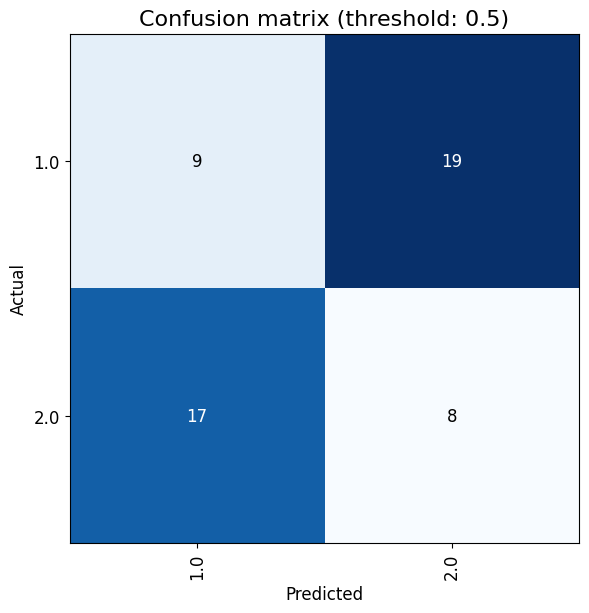

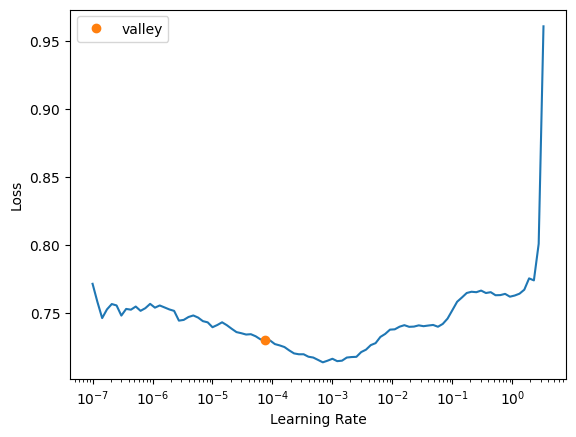

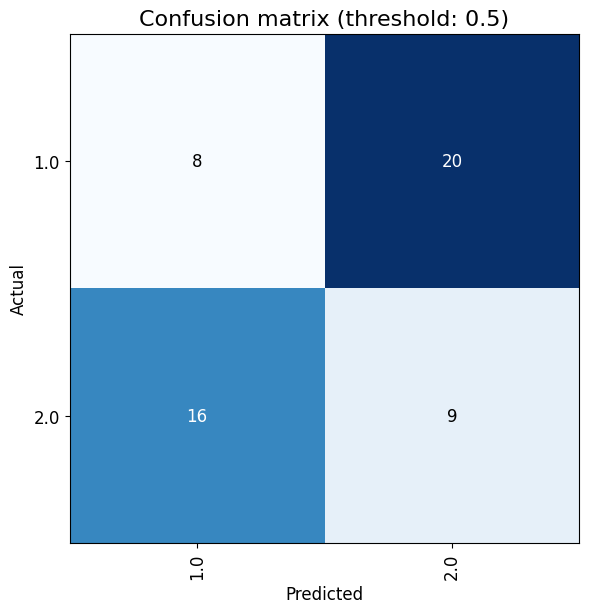

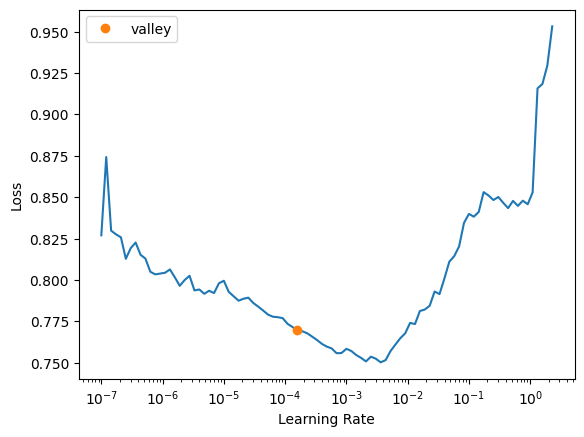

In [5]:
from tsai.all import *
import pandas as pd
from datenverarbeitung.dataloader import dataloader
from IPython.display import clear_output
import datetime

num_scenario = 3
nr_taps = 1
tap_sizes = [10,20,30,40,50,60,70,80]
movers = [20,15,10,5, 0, -5, -10, -15, -20]
all_features = ["nosetip_x","nosetip_y","chin_x","chin_y","left_eye_corner_x","left_eye_corner_y","right_eye_corner_x","right_eye_corner_y","left_mouth_corner_x","left_mouth_corner_y","right_mouth_corner_x","right_mouth_corner_y","nose_end_point_x","nose_end_point_y","head_pose1_x","head_pose1_y","head_pose2_x","head_pose2_y", "pitch","roll","yaw"]
features_to_learn_with = []
learning_cycles = 25
current_time= datetime.datetime.now().strftime('%d%m%Y_%H%M%S')
feature_list_string = '_'.join(features_to_learn_with)
models_folder = "models/compare_multivariate" 
plots_folder = "vis/plots/compare_multivariate" 

for i in range(0,len(all_features),2):
    if (i<len(all_features)-2):
        features_to_learn_with.append(all_features[i])
        features_to_learn_with.append(all_features[i+1])
    else :
        features_to_learn_with.append(all_features[i])
    for tap_size in tap_sizes:
        for move_by in movers:
            dl = dataloader(scenario= num_scenario, path="/home/adi/cloudy_adlu/smart_hans/AP2/Daten/zum_sichten/laeuft/", nr_taps=nr_taps, move_window_by=move_by, tap_size=tap_size, feature_list=features_to_learn_with)
            df_n = dl.df

            cols = list(df_n.columns)
            a, b = cols.index('sample_index'), cols.index('feature')
            cols[b], cols[a] = cols[a], cols[b]
            df_n = df_n[cols]
            df_n = df_n.sort_values(['feature','target'])#.reset_index(drop=True)

            X, old_y, names = df2xy (df_n, sample_col='sample_index', feat_col='feature', target_col='target', data_cols=None, steps_in_rows=True, return_names=True)

            y = np.empty(len(old_y))
            for i, elem in enumerate(old_y):
                        remainder = int(elem[0]) % 10
                        y[i] = remainder
            
            splits = get_splits(y, valid_size=.2)

            tfms  = [None, TSRegression()]

            dsets = TSDatasets( X,y,  inplace=True, splits=splits, tfms=[None, TSClassification()])
            dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, num_workers=0, tfms=[None, TSClassification()], item_tfs=TSClassification())

            dls.show_batch(sharey=True)

            archs = [(FCN, {}), (ResNet, {}), (xresnet1d34, {}), (ResCNN, {}), 
                    (LSTM, {'n_layers':1, 'bidirectional': False}), (LSTM, {'n_layers':2, 'bidirectional': False}), (LSTM, {'n_layers':3, 'bidirectional': False}), 
                    (LSTM, {'n_layers':1, 'bidirectional': True}), (LSTM, {'n_layers':2, 'bidirectional': True}), (LSTM, {'n_layers':3, 'bidirectional': True}),
                    (LSTM_FCN, {}), (LSTM_FCN, {'shuffle': False}), (InceptionTime, {}), (XceptionTime, {}), (OmniScaleCNN, {})]

            results = pd.DataFrame(columns=['arch', 'hyperparams',  'train loss', 'valid loss', 'accuracy', 'time'])
            for i, (arch, k) in enumerate(archs):

                save_name = "multivariate_scenario_{}_{}_features_{}_tapsize_{}_mv_{}".format(num_scenario, arch.__name__,str(len(features_to_learn_with)),tap_size, move_by)
                ## set parameters for modelsaves
                scenario_name_stage0 = save_name+"_nr_taps_{}".format(str(nr_taps))+"_stage0"

                model = create_model(arch, dls=dls, **k)
                print(model.__class__.__name__)
                learn = Learner(dls, model,  metrics=accuracy, model_dir=models_folder)

                learn.save(scenario_name_stage0)
                learn.load(scenario_name_stage0)
                learn.lr_find()
                scenario_name_stage1 = scenario_name_stage0.replace("0","1")

                start = time.time()
                learn.fit_one_cycle(learning_cycles, 1e-3)
                elapsed = time.time() - start
                vals = learn.recorder.values[-1]
                results.loc[i] = [arch.__name__, k, vals[0], vals[1], vals[2], int(elapsed)]
                results.sort_values(by='accuracy', ascending=False, ignore_index=True, inplace=True)
                
                learn.plot_confusion_matrix()
                learn.save(scenario_name_stage1)
                current_time= datetime.datetime.now().strftime('%d%m%Y_%H%M%S')
                plot_name = plots_folder+"/confusion_matrix_"+save_name+"_nrtaps_{}_learning_cycles_{}_{}.png".format(str(nr_taps),learning_cycles, current_time)
                plt.savefig(plot_name, format='png', bbox_inches="tight")
                clear_output(wait=True)
                display(results)
